# Keck 2 Polarization Model

Here we create a model of the Keck 2 telescope + AO Bench to determine the transformation of the generally polarized field through the system. We've loaded a poke.Rayfront generated on a windows maching using a Zemax OpticStudio (ZOS) raytrace of the observatory.

In [7]:
from poke.writing import read_serial_to_rayfront
from hcipy import *
from poke.interfaces import rayfront_to_hcipy_wavefront
import poke.plotting as plot
from poke.poke_math import np
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
pth = 'rayfronts/k2_acam_64rays_633nm.msgpack'
rf = read_serial_to_rayfront(pth)

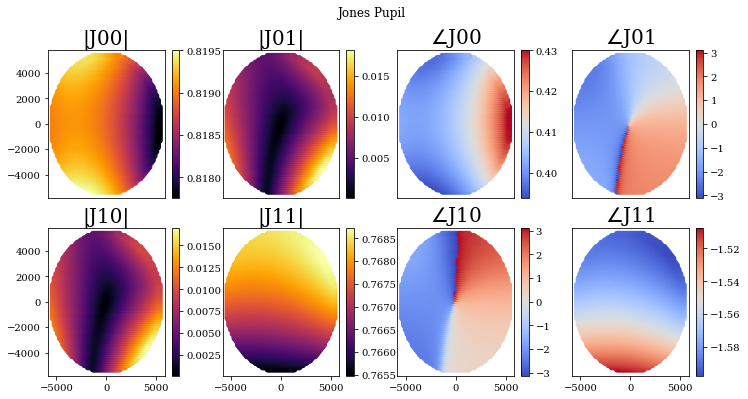

In [2]:
plot.jones_pupil(rf)

## More realistic Coatings
I used a dummy coating of n = 0.4 + 7i on the prior coating just to generate something but we should model the observatory more realistically. What materials do we need?

**The Telescope**
- M1: https://www.keckobservatory.org/keeping_keck_telescopes_shiny/ claims that the primary mirror is aluminum, maybe it's a safe bet to just use Al for the observatory optics?

In [5]:
def rotmat2d(theta):
    return np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])

# Jones pupil parameters for this raytrace
a = np.array([0.9781476007,-0.2079116908, 0.0000000000])
ap = np.array([0.9851019261,-0.1719714953, 0.0000000000]) # ray from edge of pupil
x = np.cross(a,ap)
x /= np.linalg.norm(x)

# lambda = 633nm
n_Al = 1.4495 + 1j*7.5387
n_Ag = 0.056206 + 1j*4.2776
n_ZD = 1.5403
n_SiO2 = 1.4570
n_MgF2 = 1.3770

al_coat = [(n_Ag,120e-9),(n_ZD)]
ag_coat = [(n_MgF2,54e-9),(n_Ag,120e-9),(n_ZD)]

# set up surfaces
m1 = {'coating':al_coat,'surf':1,'mode':'reflect'} # Al
m2 = {'coating':al_coat,'surf':2,'mode':'reflect'} # Al
m3 = {'coating':al_coat,'surf':4,'mode':'reflect'} # Al

hwp = rotmat2d(0) @ np.array([[1,0],[0,np.exp(1j*np.pi/2)]]) @ rotmat2d(0)

k1 = {'coating':hwp,'surf':10,'mode':'reflect'} # Al
k2 = {'coating':ag_coat,'surf':13,'mode':'reflect'} # Opticoat protected silver or FSS99 Denton
k3 = {'coating':ag_coat,'surf':16,'mode':'reflect'} # Al

tt = {'coating':ag_coat,'surf':20,'mode':'reflect'} # remainder are Opticoat or FSS99 Denton
o1 = {'coating':ag_coat,'surf':25,'mode':'reflect'}
pu = {'coating':ag_coat,'surf':30,'mode':'reflect'}
o2 = {'coating':ag_coat,'surf':33,'mode':'reflect'}
di = {'coating':ag_coat,'surf':36,'mode':'reflect'}

sod = {'coating':ag_coat,'surf':40,'mode':'reflect'}
ifm = {'coating':ag_coat,'surf':43,'mode':'reflect'}
afm = {'coating':ag_coat,'surf':46,'mode':'reflect'}

# now we want to twist a half waveplate, so update the HWP model
angles = np.linspace(0,2*np.pi,25)

# Set up the HCIPy stuff
npix = 1024
pupil_grid = make_pupil_grid(npix)
aperture = make_elt_aperture(True)(pupil_grid)
# Unpolarized Star
stokes_vector_planet = [1, 0.1, 0, 0]
contrast = 2e-4
angular_separation = 3 # lambda / D
num_photons_star = 1e9
focal_grid = make_focal_grid(8, 8)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
beamshifts = []
diffplots = []

for angle in angles:

    # update hwp
    hwp = rotmat2d(angle) @ np.array([[1,0],[0,np.exp(1j*np.pi/2)]]) @ rotmat2d(angle)

    # update surfdict
    k1 = {'coating':hwp,'surf':10,'mode':'reflect'} # Al

    # update surfface list
    rf.surfaces = [m1,m2,m3,k1,k2,k3,tt,o1,pu,o2,di,sod,ifm,afm]

    # compute jones pupil
    rf.compute_jones_pupil(aloc=a,exit_x=x)
    # Convert to hcipy wavefront
    partially_polarized_wavefront = rayfront_to_hcipy_wavefront(rf,npix,pupil_grid,input_stokes_vector=[1,0,0,0])
    partially_polarized_wavefront.electric_field *= aperture # apply the magellan aperture
    # Apply to a star and a planet
    wf_star = partially_polarized_wavefront #(aperture)
    wf_star.total_power = num_photons_star
    jones_matrix = partially_polarized_wavefront.electric_field

    e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
    wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
    wf_planet.total_power = num_photons_star * contrast
    
    pbs = LinearPolarizingBeamSplitter(0)

    img_star_1, img_star_2 = pbs((prop(wf_star)))
    img_planet_1, img_planet_2 = pbs((prop(wf_planet)))

    science_image_1 = img_star_1.power + img_planet_1.power
    science_image_2 = img_star_2.power + img_planet_2.power

    science_image_1 = large_poisson(science_image_1)
    science_image_2 = large_poisson(science_image_2)

    # compute the differential beamshift
    com1 = center_of_mass(np.array(science_image_1.shaped))
    com2 = center_of_mass(np.array(science_image_2.shaped))
    beamshift = np.sqrt((com1[0]-com2[0])**2 + (com1[1] - com2[1])**2)
    beamshifts.append(beamshift/8 * 1.550e-6 / 10.95 * 206265)
    diffplots.append(np.array((science_image_1.shaped - science_image_2.shaped) / science_image_1.max()))

Now we construct a polarization model with HCIPy, follow the example!

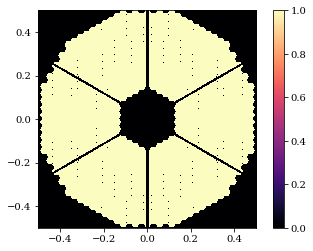

In [23]:
npix = 1024
pupil_grid = make_pupil_grid(npix)
aperture = make_elt_aperture(True)(pupil_grid)

plt.figure()
imshow_field(aperture)
plt.colorbar()
plt.show()

(1048576, 12)


<ipython-input-24-50c3e0812379>:4: RuntimeWarning: invalid value encountered in divide
  imshow_field(partially_polarized_wavefront.intensity/aperture)


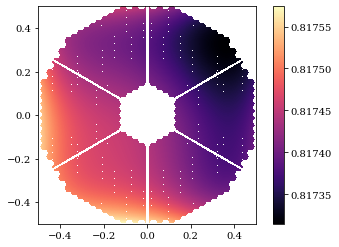

In [24]:
partially_polarized_wavefront = rayfront_to_hcipy_wavefront(rf,npix,pupil_grid,input_stokes_vector=[1,0,0,0])
partially_polarized_wavefront.electric_field *= aperture # apply the magellan aperture
plt.figure()
imshow_field(partially_polarized_wavefront.intensity/aperture)
plt.colorbar()
plt.show()

In [25]:
focal_grid = make_focal_grid(8, 8)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
partially_polarized_image = prop(partially_polarized_wavefront)

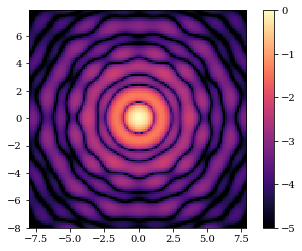

In [26]:
# Unpolarized Star
stokes_vector_planet = [1, 0.1, 0, 0]
contrast = 2e-4
angular_separation = 3 # lambda / D
num_photons_star = 1e9

wf_star = partially_polarized_wavefront #(aperture)
wf_star.total_power = num_photons_star
jones_matrix = partially_polarized_wavefront.electric_field

e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
wf_planet.total_power = num_photons_star * contrast

# Calculate science image for the star and planet
science_image = prop(wf_star).power
science_image += prop(wf_planet).power

# Simulate photon noise
science_image = large_poisson(science_image)

imshow_field(np.log10(science_image / science_image.max() + 1e-20), vmin=-5, vmax=0)
plt.colorbar()
plt.show()

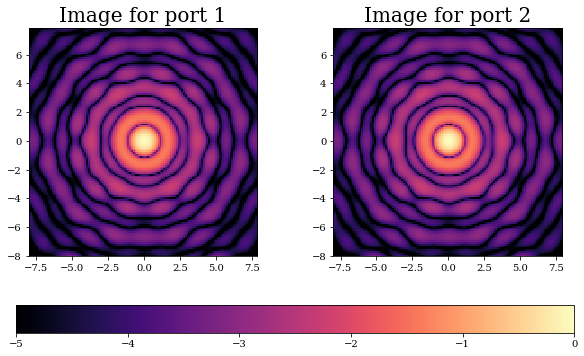

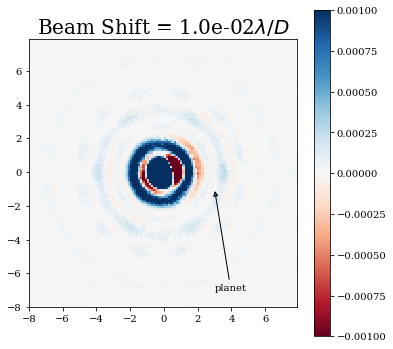

In [27]:
pbs = LinearPolarizingBeamSplitter(0)

img_star_1, img_star_2 = pbs(prop(wf_star))
img_planet_1, img_planet_2 = pbs(prop(wf_planet))

science_image_1 = img_star_1.power + img_planet_1.power
science_image_2 = img_star_2.power + img_planet_2.power

science_image_1 = large_poisson(science_image_1)
science_image_2 = large_poisson(science_image_2)

fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

axes[0].set_title('Image for port 1')
imshow_field(np.log10(science_image_1 / science_image_1.max() + 1e-20), vmin=-5, vmax=0, ax=axes[0])

axes[1].set_title('Image for port 2')
imshow_field(np.log10(science_image_2 / science_image_2.max() + 1e-20), vmin=-5, vmax=0, ax=axes[1])

plt.colorbar(ax=axes.tolist(), orientation="horizontal")
plt.show()

# compute the differential beamshift
from scipy.ndimage import center_of_mass
com1 = center_of_mass(np.array(science_image_1.shaped))
com2 = center_of_mass(np.array(science_image_2.shaped))
beamshift = np.sqrt((com1[0]-com2[0])**2 + (com1[1] - com2[1])**2)

plt.figure(figsize=[6,6])
plt.title(f'Beam Shift = {beamshift/8:.1e}'+r'$\lambda/D$')
imshow_field((science_image_1 - science_image_2) / science_image_1.max(), cmap='RdBu',vmin=-1e-3,vmax=1e-3)
plt.annotate('planet', xy=(3, -1), xytext=(3, -7), arrowprops={'arrowstyle': '-|>'})
plt.colorbar()
plt.show()

In [28]:
# try beamshift v.s. polarizer angle
angles = np.linspace(0,np.pi/2,100)
beamshifts = []
diffplots = []
for angle in angles:
    hwp = HalfWavePlate(angle)
    pbs = LinearPolarizingBeamSplitter(0)

    img_star_1, img_star_2 = pbs(hwp(prop(wf_star)))
    img_planet_1, img_planet_2 = pbs(hwp(prop(wf_planet)))

    science_image_1 = img_star_1.power + img_planet_1.power
    science_image_2 = img_star_2.power + img_planet_2.power

    science_image_1 = large_poisson(science_image_1)
    science_image_2 = large_poisson(science_image_2)

    

    # compute the differential beamshift
    com1 = center_of_mass(np.array(science_image_1.shaped))
    com2 = center_of_mass(np.array(science_image_2.shaped))
    beamshift = np.sqrt((com1[0]-com2[0])**2 + (com1[1] - com2[1])**2)
    beamshifts.append(beamshift/8 * 1.550e-6 / 10.95 * 206265)
    diffplots.append(np.array((science_image_1.shaped - science_image_2.shaped) / science_image_1.max()))


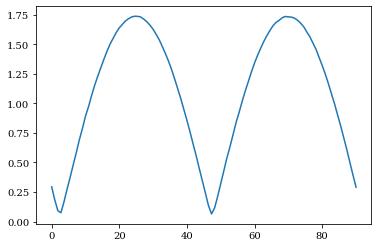

In [29]:
plt.plot(np.degrees(angles),[i*1e3 for i in beamshifts])

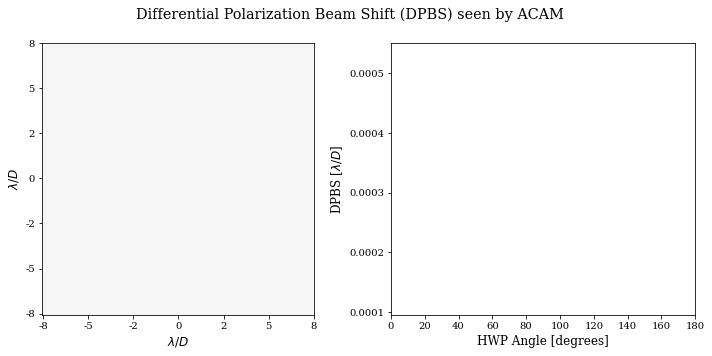

In [11]:
from matplotlib import animation
from IPython.display import HTML
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=[12,5])

# # Initialize the line plot
line, = ax2.plot(angles, beamshifts, 'r-', lw=2)

# # Set up the imshow plot
im = ax1.imshow(np.zeros_like(np.array(science_image_2.shaped)),cmap='RdBu',vmin=-1e-3,vmax=1e-3, animated=True)

# Define the initialization function
def init():
    im.set_array(np.zeros_like(np.array(science_image_2.shaped)))  # Set initial data for imshow plot
    line.set_data([], [])  # Clear line plot
    return im , line

# Define the update function for the animation
def update(i):
    # Update data for imshow plot
    im.set_array(diffplots[i])
    
    # Update data for line plot
    line.set_data(np.degrees(angles)[:i], beamshifts[:i])
    
    return im , line

# Create the animation

# make it pretty
fs = 12
ticks = np.linspace(-8,8,7)
tickpos = np.linspace(0,128,7)
ticks = [int(i) for i in ticks]
ax2.set_xlim([0,180])
ax1.set_xticks(tickpos)
ax1.set_xticklabels(ticks)
ax1.set_yticks(tickpos)
ax1.set_yticklabels(ticks)
ax2.set_ylabel('DPBS '+r'[$\lambda/D$]',fontsize=fs)
ax1.set_xlabel(r'$\lambda/D$',fontsize=fs)
ax1.set_ylabel(r'$\lambda/D$',fontsize=fs)
ax2.set_xlabel('HWP Angle [degrees]',fontsize=fs)
ax1_divider = make_axes_locatable(ax1)
# Add an Axes to the right of the main Axes.
# cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
# fig.colorbar(im,cax=cax1)
plt.suptitle('Differential Polarization Beam Shift (DPBS) seen by ACAM',fontsize=fs*1.2)
ani = animation.FuncAnimation(fig, update, frames=len(diffplots), interval=40, init_func=init)
HTML(ani.to_html5_video())

In [39]:
# ani.save('acam_dpbs.gif')
print(len(diffplots))
print(len(beamshifts))

125
125


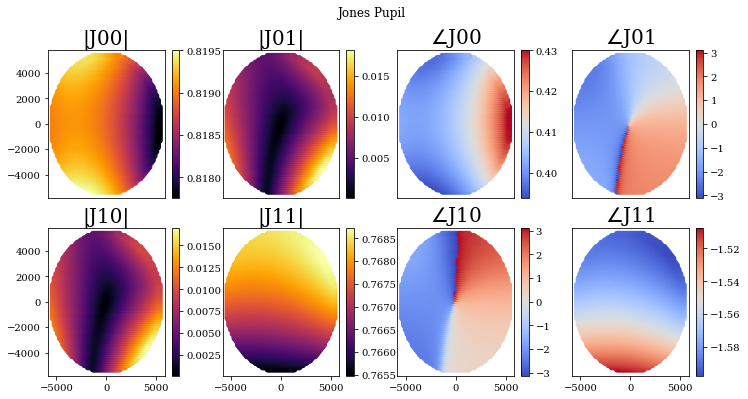